Original Dataset Shape: (121575, 24)


C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



--- After Train-Test Split ---
Original Class Distribution:
 RainTomorrow
0.0    0.773901
1.0    0.226099
Name: proportion, dtype: float64
Training Set Class Distribution:
 RainTomorrow
0.0    0.773907
1.0    0.226093
Name: proportion, dtype: float64
Testing Set Class Distribution:
 RainTomorrow
0.0    0.773888
1.0    0.226112
Name: proportion, dtype: float64

--- Oversampling the Training Data ---
Class distribution after oversampling:
 RainTomorrow
0.0    65861
1.0    65861
Name: count, dtype: int64

--- Outlier Removal on Resampled Training Data ---
Shape of resampled data: (131722, 24)
Shape of final training data after outlier removal: (93863, 24)
Final class distribution:
 RainTomorrow
0.0    0.612179
1.0    0.387821
Name: proportion, dtype: float64

Pearson Correlation with RainTomorrow (on Resampled Training Data):
 RainTomorrow     1.000000
RISK_MM          0.754462
Cloud3pm         0.449872
Humidity3pm      0.441871
Cloud9am         0.349527
Rainfall         0.246093
Humidit

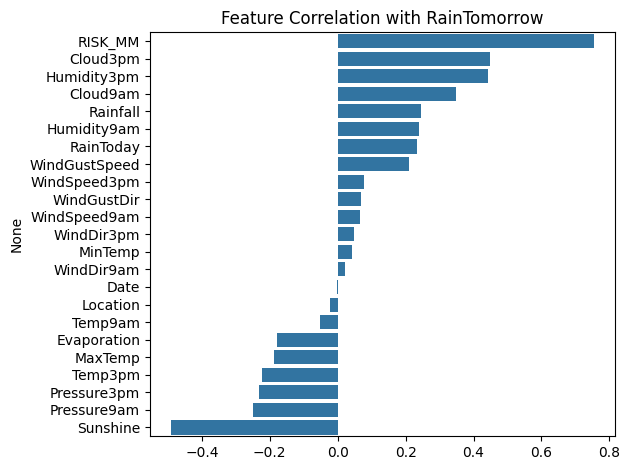

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import resample

# 1. Load dataset
dataset = pd.read_csv('Extracted-dataset.csv')
print("Original Dataset Shape:", dataset.shape)

# 2. Encode binary categorical labels
dataset['RainToday'] = dataset['RainToday'].map({'No': 0, 'Yes': 1})
dataset['RainTomorrow'] = dataset['RainTomorrow'].map({'No': 0, 'Yes': 1})

# 3. Impute object/categorical columns with mode
for col in dataset.select_dtypes(include=['object']).columns:
    dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

# 4. Label Encode categorical columns
lencoders = {}
for col in dataset.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    dataset[col] = lencoders[col].fit_transform(dataset[col])

# 5. Impute numerical columns using Iterative Imputer (MICE)
mice_imputer = IterativeImputer(random_state=42)
dataset_imputed = pd.DataFrame(mice_imputer.fit_transform(dataset), columns=dataset.columns)

# 6. Separate features (X) and target (y)
X = dataset_imputed.drop('RainTomorrow', axis=1)
y = dataset_imputed['RainTomorrow']

# 7. Split data into training and testing sets, using 'stratify'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\n--- After Train-Test Split ---")
print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Training Set Class Distribution:\n", y_train.value_counts(normalize=True))
print("Testing Set Class Distribution:\n", y_test.value_counts(normalize=True))

# 8. Oversample the minority class on the TRAINING DATA ONLY
# We do this BEFORE outlier removal, as the minority class instances can be mistaken for outliers.
print("\n--- Oversampling the Training Data ---")
df_train_combined = pd.concat([X_train, y_train], axis=1)
minority_class = df_train_combined[df_train_combined['RainTomorrow'] == 1]
majority_class = df_train_combined[df_train_combined['RainTomorrow'] == 0]

if not minority_class.empty:
    minority_oversampled = resample(minority_class,
                                    replace=True,
                                    n_samples=len(majority_class),
                                    random_state=42)
    df_train_resampled = pd.concat([majority_class, minority_oversampled])
else:
    print("⚠️ Minority class is empty. Oversampling not performed.")
    df_train_resampled = df_train_combined.copy()

print("Class distribution after oversampling:\n", df_train_resampled['RainTomorrow'].value_counts())

# 9. Now, remove outliers from the BALANCED training data
# This is a safer approach as the minority class is now well-represented.
print("\n--- Outlier Removal on Resampled Training Data ---")
Q1 = df_train_resampled.quantile(0.25)
Q3 = df_train_resampled.quantile(0.75)
IQR = Q3 - Q1
cleaned_resampled = df_train_resampled[~((df_train_resampled < (Q1 - 1.5 * IQR)) | (df_train_resampled > (Q3 + 1.5 * IQR))).any(axis=1)]

X_train_final = cleaned_resampled.drop('RainTomorrow', axis=1)
y_train_final = cleaned_resampled['RainTomorrow']

print("Shape of resampled data:", df_train_resampled.shape)
print("Shape of final training data after outlier removal:", cleaned_resampled.shape)

# 10. Final class balance check
print("Final class distribution:\n", y_train_final.value_counts(normalize=True))

# 11. Pearson Correlation with RainTomorrow
correlation_with_target = cleaned_resampled.corr()['RainTomorrow'].sort_values(ascending=False)
print("\nPearson Correlation with RainTomorrow (on Resampled Training Data):\n", correlation_with_target)

sns.barplot(
    x=correlation_with_target.drop('RainTomorrow').values,
    y=correlation_with_target.drop('RainTomorrow').index
)
plt.title('Feature Correlation with RainTomorrow')
plt.tight_layout()
plt.show()

# Now you can use X_train_final and y_train_final to train your model,
# and use X_test and y_test for evaluation.

--- Starting Model Training and Evaluation ---

--- Training Logistic Regression ---
--- Evaluating Logistic Regression on Test Data ---
ROC AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28226
         1.0       1.00      1.00      1.00      8247

    accuracy                           1.00     36473
   macro avg       1.00      1.00      1.00     36473
weighted avg       1.00      1.00      1.00     36473



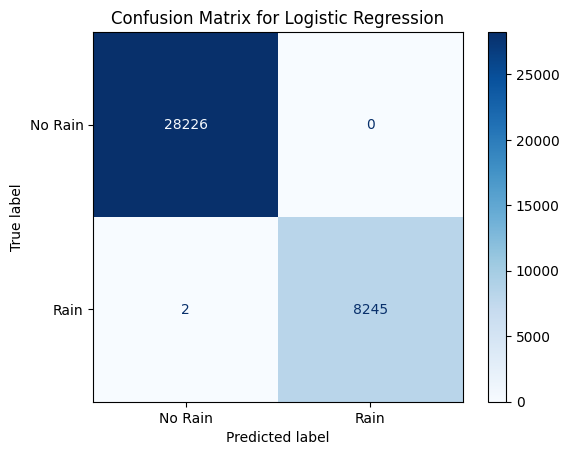


--- Training Random Forest ---
--- Evaluating Random Forest on Test Data ---
ROC AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28226
         1.0       1.00      1.00      1.00      8247

    accuracy                           1.00     36473
   macro avg       1.00      1.00      1.00     36473
weighted avg       1.00      1.00      1.00     36473



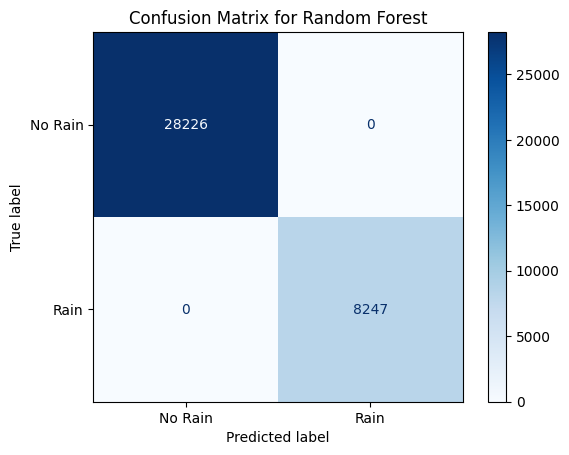


--- Training XGBoost ---


C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [13:46:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluating XGBoost on Test Data ---
ROC AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28226
         1.0       1.00      1.00      1.00      8247

    accuracy                           1.00     36473
   macro avg       1.00      1.00      1.00     36473
weighted avg       1.00      1.00      1.00     36473



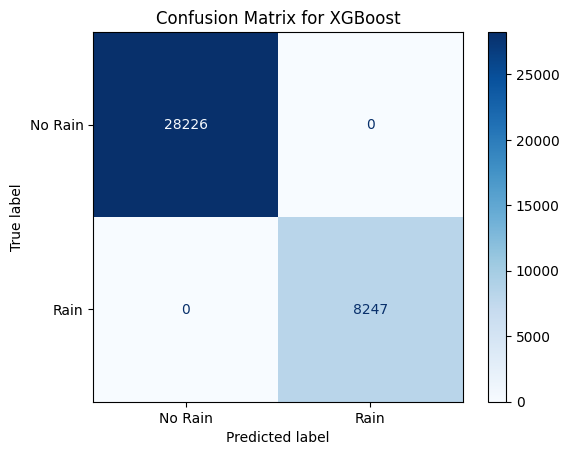


--- Model Comparison Summary ---
                 Model  ROC_AUC  Precision_1  Recall_1  F1-Score_1
1        Random Forest      1.0          1.0  1.000000    1.000000
2              XGBoost      1.0          1.0  1.000000    1.000000
0  Logistic Regression      1.0          1.0  0.999757    0.999879


C:\Users\Asus\AppData\Local\Temp\ipykernel_24980\1408654630.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, pd.DataFrame([{


NameError: name 'roc_curve' is not defined

<Figure size 1000x800 with 0 Axes>

In [4]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume the following variables are available from the previous steps:
# X_train_final, y_train_final  (your balanced and cleaned training data)
# X_test, y_test              (your untouched test data)

# 1. Initialize models
#    We use 'class_weight='balanced'' for Logistic Regression and Random Forest
#    For XGBoost, we use the 'scale_pos_weight' parameter to handle the imbalance
#    in case it's still present or to give more weight to the minority class.
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Dictionary to store results for comparison
results = {}

# 2. Train and evaluate each model
print("--- Starting Model Training and Evaluation ---")
for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train_final, y_train_final)
    
    print(f"--- Evaluating {model_name} on Test Data ---")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Store key metrics
    results[model_name] = {
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }

    # Print results
    print(f"ROC AUC Score: {results[model_name]['ROC_AUC']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Optional: Plot Confusion Matrix for each model
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f"Confusion Matrix for {model_name}")
    plt.show()

# 3. Compare the models
print("\n--- Model Comparison Summary ---")
performance_df = pd.DataFrame(columns=['Model', 'ROC_AUC', 'Precision_1', 'Recall_1', 'F1-Score_1'])

for model_name, metrics in results.items():
    precision_1 = metrics['Classification Report']['1.0']['precision']
    recall_1 = metrics['Classification Report']['1.0']['recall']
    f1_score_1 = metrics['Classification Report']['1.0']['f1-score']
    
    performance_df = pd.concat([performance_df, pd.DataFrame([{
        'Model': model_name,
        'ROC_AUC': metrics['ROC_AUC'],
        'Precision_1': precision_1,
        'Recall_1': recall_1,
        'F1-Score_1': f1_score_1
    }])], ignore_index=True)

# Sort by ROC_AUC for easy comparison
performance_df = performance_df.sort_values(by='ROC_AUC', ascending=False)
print(performance_df)

# Optional: Visualize ROC curves for all models on one plot
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Final Conclusion ---")
best_model = performance_df.iloc[0]['Model']
print(f"Based on ROC AUC and F1-Score for the minority class, the best performing model appears to be: {best_model}")